<h1>Cerebral/Psychological problems in IT Industry:</h1> 
<br>
In below piece of code we are doing following:<br>
1) Loading the important modules.<br>
2) checking the number of fields loaded and number of records.<br>
3) check distribution of data: Only age is numerical(Looking at its summary we can't say anything about its distibution either). Rest is all string.<br>
4) Looking at the data we can see comments and state has the most missing data.<br>


In [1800]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import randint

# prep
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score

#Neural Network
from sklearn.grid_search import RandomizedSearchCV

#Bagging
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

#Naive bayes
from sklearn.naive_bayes import GaussianNB 


#reading in CSV's from a file path
train_df = pd.read_csv('./input/Data.csv')


#Pandas: whats the data row count?
print("Dataset has "+ str(train_df.shape[0]) +" records and "+ str(train_df.shape[1]) + " fields")
print()    
#Pandas: whats the distribution of the data?
print(train_df.describe())
    
#Pandas: What types of data do i have?
print(train_df.info())
print()

Dataset has 1259 records and 26 fields

                Age
count  1.259000e+03
mean   7.942815e+07
std    2.818299e+09
min   -1.726000e+03
25%    2.700000e+01
50%    3.100000e+01
75%    3.600000e+01
max    1.000000e+11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 26 columns):
Age                          1259 non-null int64
Gender                       1259 non-null object
Country                      1259 non-null object
state                        744 non-null object
self_employed                1241 non-null object
family_history               1259 non-null object
treatment                    1259 non-null object
work_interfere               995 non-null object
no_employees                 1259 non-null object
remote_work                  1259 non-null object
tech_company                 1259 non-null object
benefits                     1259 non-null object
care_options                 1259 non-null object
wellness_program          

<div style="color: #483d8b;"><b>Thus, in below step we drop 'comments', 'State' and 'TimeStamp' columns because TimeStamp won't help identify anything as it is the time when data was collected(In the first run I did not remove it, discretized it by month but it was eventually reducing accuracy. Thus, dropped it.) whereas state and comments have high missing values and can't be used for any kind of analysis.</b></div>


In [1801]:
print("ColumnWise Missing values Percentage:") 
check2=train_df.isnull().sum()*100/1259
check2.sort_values(inplace=True, ascending=False)
print(check2.head(5))
check=train_df.nunique()
check.sort_values(inplace=True, ascending=False)
print()
print("Unique values per Column:")
print(check.head(5))
train_df = train_df.drop(['comments','state'], axis= 1)

ColumnWise Missing values Percentage:
comments           86.973789
state              40.905481
work_interfere     20.969023
self_employed       1.429706
obs_consequence     0.000000
dtype: float64

Unique values per Column:
comments    160
Age          53
Gender       49
Country      48
state        45
dtype: int64


<div style="color: #483d8b;"><b>In next steps we analyse each attribute values:<Br>
Age: We:<br>
1) Analyse if there are outliers in Age.<br> 
2) Check their count<br> 
3) Analyse how to take care of them.</b></div>

Age
-1726           1
-29             1
-1              1
 329            1
 99999999999    1
dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



Text(0.5,0,'Age')

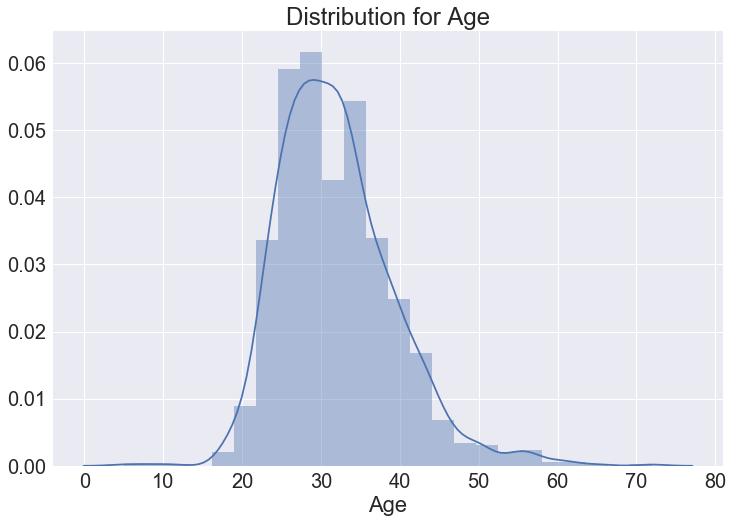

In [1802]:
print(train_df[(train_df['Age']>100) | (train_df['Age']<0)].groupby(['Age']).size())

l=list(train_df[(train_df['Age']<100) & (train_df['Age']>0)]['Age'])

plt.figure(figsize=(12,8))
sns.distplot(l, bins=24)
plt.title("Distribution for Age")
plt.xlabel("Age")

<div style="color: #483d8b;"><b>1) From above Diagram it is clear that the Age is following normal distribution and as the number of values that are missing is really small we can simply use median value to fill up the missing values. Mean was not used because of outliers mean comes out to be a really high value.<br></div> 

In [1803]:
s = pd.Series(train_df['Age'])
s[s<18] = train_df['Age'].median()
train_df['Age'] = s
s = pd.Series(train_df['Age'])
s[s>100] = train_df['Age'].median()
train_df['Age'] = s

train_df['age_range'] = pd.cut(train_df['Age'], [0,20,30,65,100], labels=[0,1,2,3], include_lowest=True)
assert(train_df.groupby(['age_range']).size().sum() == train_df.shape[0])

<div style="color: #483d8b;"><b>Next variable to be treated is Gender: <br>
1) We first check unique values for the variable<br>
2) Then assessing each value we assign it one of the labels "male","female","trans"<br>
3) There are also 2 records with odd values. I am assigning the most popular label to these 2 records.<br></div></b>

In [1804]:
print(train_df['Gender'].unique())

male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in train_df.iterrows():

 if str.lower(col.Gender) in male_str:
  train_df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

 if str.lower(col.Gender) in female_str:
  train_df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

 if str.lower(col.Gender) in trans_str:
  train_df['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

#for feature in stringFeatures:
        #train_df[feature] = train_df[feature].fillna(defaultString)
print()
print(train_df.groupby(['Gender']).size())

stk_list = ['A little about you', 'p']

for feat in stk_list:
 train_df.loc[train_df['Gender'] == feat , 'Gender'] = 'male'

print("\n\nAfter removing the 2 odd records:")
print(train_df.groupby(['Gender']).size())

['Female' 'M' 'Male' 'male' 'female' 'm' 'Male-ish' 'maile' 'Trans-female'
 'Cis Female' 'F' 'something kinda male?' 'Cis Male' 'Woman' 'f' 'Mal'
 'Male (CIS)' 'queer/she/they' 'non-binary' 'Femake' 'woman' 'Make' 'Nah'
 'All' 'Enby' 'fluid' 'Genderqueer' 'Female ' 'Androgyne' 'Agender'
 'cis-female/femme' 'Guy (-ish) ^_^' 'male leaning androgynous' 'Male '
 'Man' 'Trans woman' 'msle' 'Neuter' 'Female (trans)' 'queer'
 'Female (cis)' 'Mail' 'cis male' 'A little about you' 'Malr' 'p' 'femail'
 'Cis Man' 'ostensibly male, unsure what that really means']

Gender
A little about you      1
female                247
male                  991
p                       1
trans                  19
dtype: int64


After removing the 2 odd records:
Gender
female    247
male      993
trans      19
dtype: int64


<div style="color: #483d8b;"><b>There are only 18 missing values for self_emmployed. So we assigned it the most popular label as well.</b></div>

In [1805]:
print(train_df.groupby(['self_employed']).size())
print("\n Number of Null Values are: {}".format(train_df['self_employed'].isnull().sum()))
train_df['self_employed'] = train_df['self_employed'].fillna('No')
print("\n Number of Null Values after update with No are: {}".format(train_df['self_employed'].isnull().sum()))
print(train_df.groupby(['self_employed']).size())

self_employed
No     1095
Yes     146
dtype: int64

 Number of Null Values are: 18

 Number of Null Values after update with No are: 0
self_employed
No     1113
Yes     146
dtype: int64


<div style="color: #483d8b;"><b>work_interfere is categorical and can have a category Unsure. Thus, we'll assign 'Don't Know' to the missing values</b></div>

In [1806]:
print(train_df.groupby(['work_interfere']).size())
train_df['work_interfere'] = train_df['work_interfere'].fillna("UnSure")
print("\n\n\n {}".format(train_df.groupby(['work_interfere']).size()))
train_df.to_csv("data", sep=',')

work_interfere
Never        213
Often        144
Rarely       173
Sometimes    465
dtype: int64



 work_interfere
Never        213
Often        144
Rarely       173
Sometimes    465
UnSure       264
dtype: int64


In [1807]:
from collections import Counter
import math
import scipy.stats as ss

def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

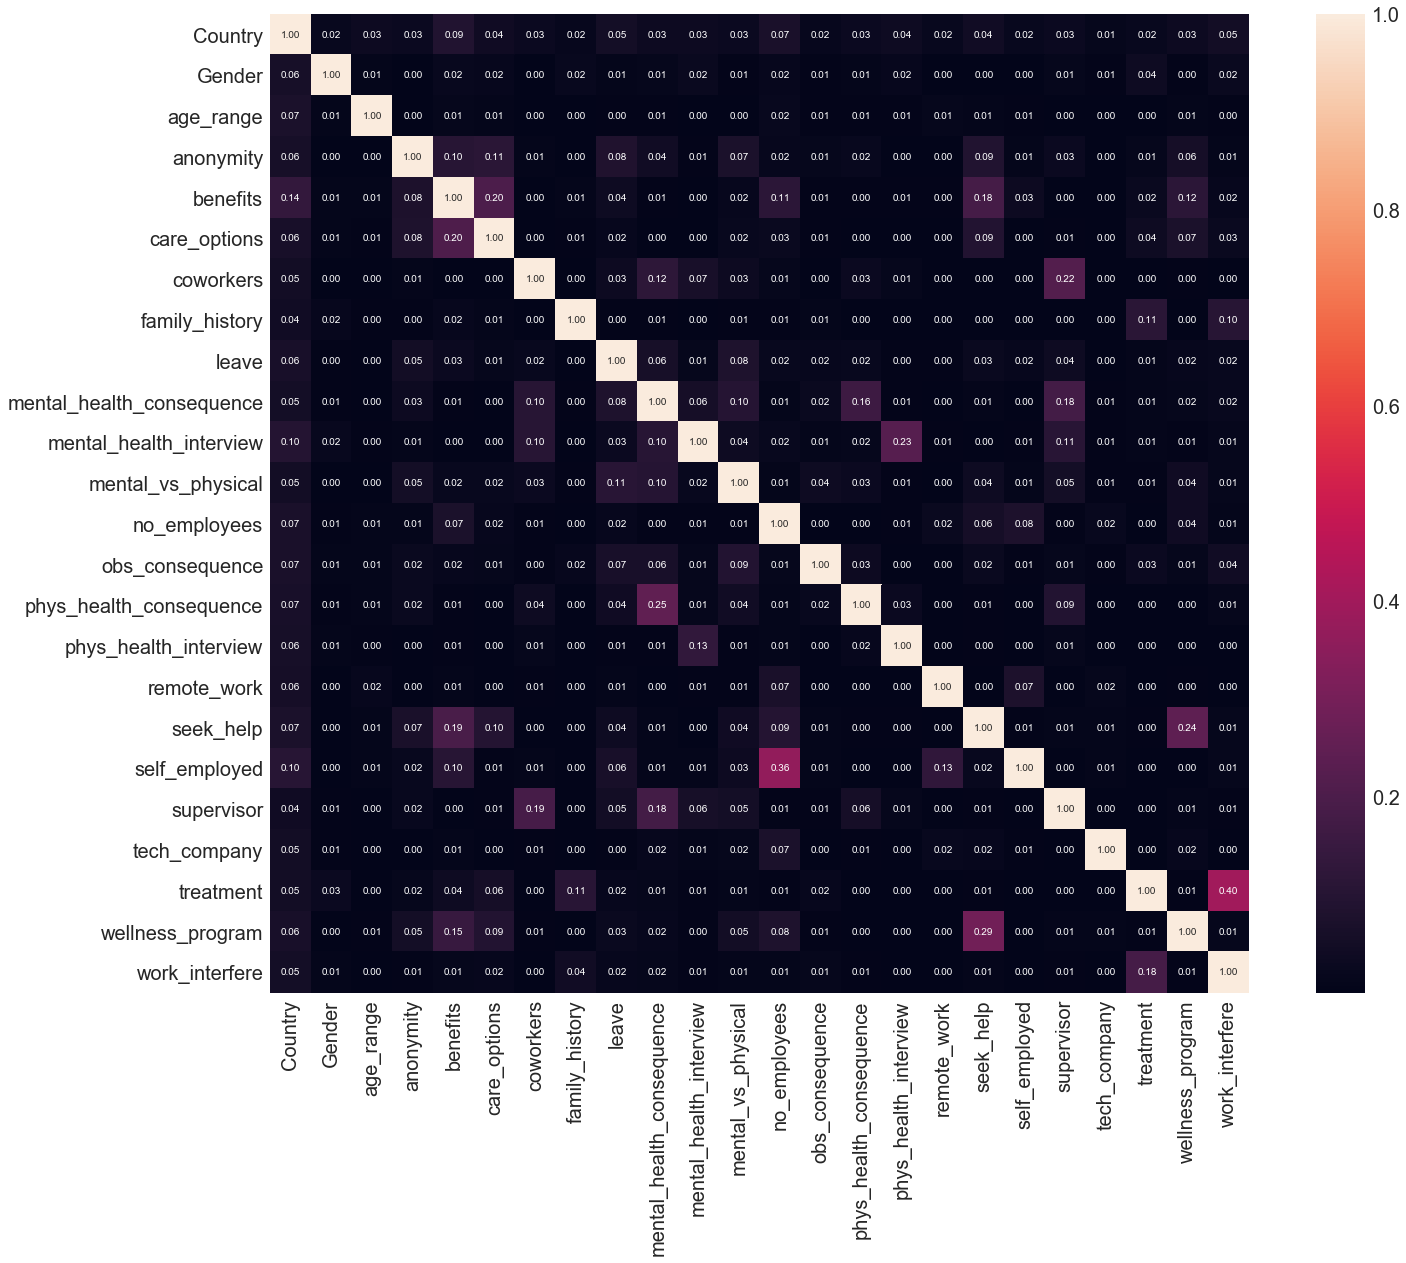

In [1808]:
f, ax = plt.subplots(figsize=(24,18))

cols=list()
outer_lis=list()
for feat in train_df[train_df.columns.difference(['Age'])]:
 cols.append(feat)
 inner_lis=list()
 for feat2 in train_df[train_df.columns.difference(['Age'])]:
  inner_lis.append(theil_u(train_df[feat],train_df[feat2]))
 outer_lis.append(inner_lis)
vals=np.array(outer_lis)

#treatment correlation matrix
k = 23
cm=vals
sns.set(font_scale=2.0)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)
plt.show()

for k in cm:
 for n in k:
    if n>0.5 and n!=1:
        print(n)



<div style="color: #483d8b;"><b>
Below is the correlation matrix:
Thus, methods like PCA won't really help as correlation is not high here.(For that we would have to do one hot encoding) 
</b> </div>

<div style="color: #483d8b;"><b>In the below steps we encode features so that they can be handled in model.</b></div>

In [1809]:
labelDict = {}
train_df_bkp = train_df.copy()
for feature in train_df:
    le = preprocessing.LabelEncoder()
    le.fit(train_df[feature])
    train_df[feature] = le.transform(train_df[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = list(le.classes_)
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)
train_df.head(5)

label_Age [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 65, 72]
label_Gender ['female', 'male', 'trans']
label_Country ['Australia', 'Austria', 'Bahamas, The', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Mexico', 'Moldova', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'United Kingdom', 'United States', 'Uruguay', 'Zimbabwe']
label_self_employed ['No', 'Yes']
label_family_history ['No', 'Yes']
label_treatment ['No', 'Yes']
label_work_interfere ['Never', 'Often', 'Rarely', 'Sometimes', 'UnSure']


,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,19,0,45,0,0,1,1,3,0,1,...,2,1,1,1,2,1,0,2,0,2
1,26,1,45,0,0,0,2,5,0,0,...,0,0,1,0,0,1,1,0,0,2
2,14,1,7,0,0,0,2,3,0,1,...,1,1,1,2,2,2,2,1,0,2
3,13,1,44,0,1,1,1,1,0,1,...,1,2,2,1,0,0,0,1,1,2
4,13,1,45,0,0,0,0,0,1,1,...,0,1,1,1,2,2,2,0,0,2


In [1810]:
#--------------Ordinal-------------------------

feats = ['26-100', '100-500','500-1000', 'More than 1000', '43586', '45809']
for ind, feat in enumerate(feats):
 train_df_bkp.loc[train_df_bkp['no_employees'] == feat , 'no_employees'] = ind
feats=['Very easy','Somewhat easy', "Don't know", 'Somewhat difficult', 'Very difficult']
for ind, feat in enumerate(feats):
 train_df_bkp.loc[train_df_bkp['leave'] == feat , 'leave'] = ind
feats=['No', 'Maybe', 'Yes']
for ind, feat in enumerate(feats):
 train_df_bkp.loc[train_df_bkp['mental_health_consequence'] == feat , 'mental_health_consequence'] = ind
 train_df_bkp.loc[train_df_bkp['phys_health_consequence'] == feat , 'phys_health_consequence'] = ind
 train_df_bkp.loc[train_df_bkp['mental_health_interview'] == feat , 'mental_health_interview'] = ind
 train_df_bkp.loc[train_df_bkp['phys_health_interview'] == feat , 'phys_health_interview'] = ind
feats=['No', 'Some of them', 'Yes']
for ind, feat in enumerate(feats):
    train_df_bkp.loc[train_df_bkp['coworkers'] == feat , 'coworkers'] = ind
    train_df_bkp.loc[train_df_bkp['supervisor'] == feat , 'supervisor'] = ind

feats=[0,1,2,3,4]
train_df_bkp['range'] = 0

for ind, feat in enumerate(feats):
    train_df_bkp.loc[train_df_bkp['age_range'] == feat , 'range'] = ind
train_df_bkp = train_df_bkp.drop(['age_range'], axis= 1)

feats=['Never','UnSure','Rarely','Often','Sometimes']

for ind, feat in enumerate(feats):
    train_df_bkp.loc[train_df_bkp['work_interfere'] == feat , 'work_interfere'] = ind


#------------binary---------------

labelDict2 = {}
for feature in ['self_employed','family_history','treatment','remote_work','tech_company','obs_consequence']:
    le = preprocessing.LabelEncoder()
    le.fit(train_df_bkp[feature])
    train_df_bkp[feature] = le.transform(train_df_bkp[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = list(le.classes_)
    labelDict2[labelKey] =labelValue

#------------One Hot Encoding for Categorical----------------

list2=['Gender', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'mental_vs_physical'] 
df_2 = pd.get_dummies(train_df_bkp[list2],drop_first=True)
train_df_bkp = train_df_bkp.drop(list2, axis= 1)
train_df_bkp = train_df_bkp.join(df_2)
train_df_bkp.head(5)



,Age,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,leave,...,care_options_Not sure,care_options_Yes,wellness_program_No,wellness_program_Yes,seek_help_No,seek_help_Yes,anonymity_No,anonymity_Yes,mental_vs_physical_No,mental_vs_physical_Yes
0,37,United States,0,0,1,3,5,0,1,1,...,1,0,1,0,0,1,0,1,0,1
1,44,United States,0,0,0,2,3,0,0,2,...,0,0,0,0,0,0,0,0,0,0
2,32,Canada,0,0,0,2,5,0,1,3,...,0,0,1,0,1,0,0,0,1,0
3,31,United Kingdom,0,1,1,3,0,0,1,3,...,0,1,1,0,1,0,1,0,1,0
4,31,United States,0,0,0,0,1,1,1,2,...,0,0,0,0,0,0,0,0,0,0


Text(0.5,1,'Total Distribuition by treated or not')

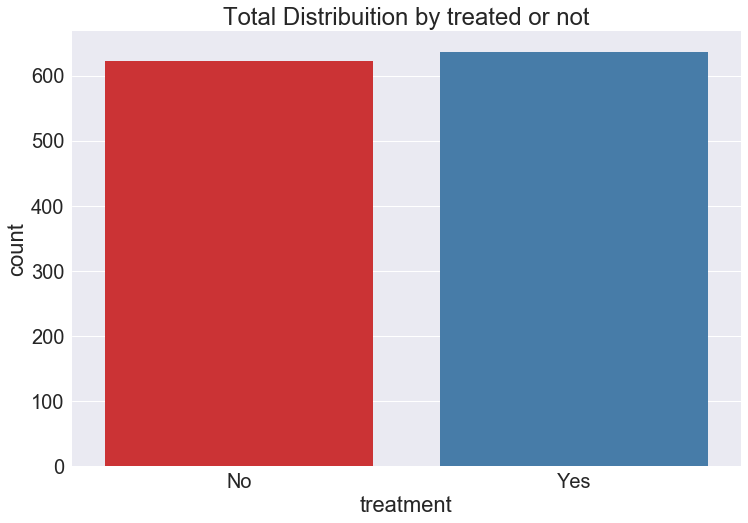

In [1811]:
plt.figure(figsize=(12,8))
labels = labelDict['label_treatment']
g = sns.countplot(x="treatment", data=train_df, palette="Set1")
g.set_xticklabels(labels)

plt.title('Total Distribuition by treated or not')

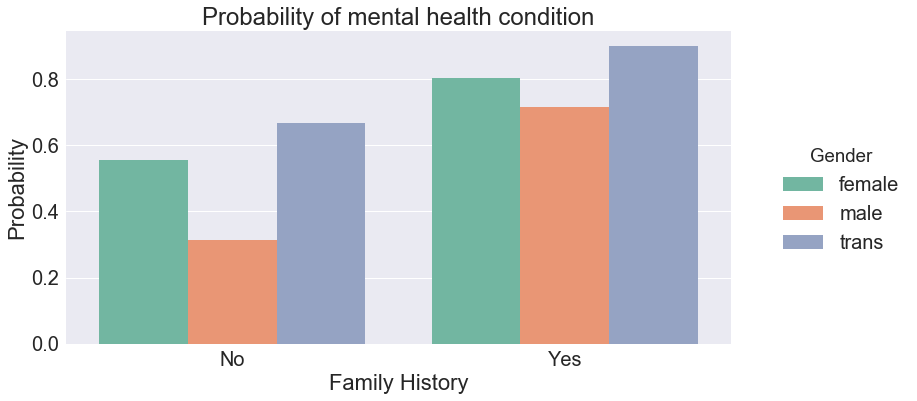

In [1812]:
o = labelDict['label_family_history']
colors=["red","blue","green"]
g = sns.factorplot(x="family_history", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=6, aspect=2, legend_out = True, palette="Set2")
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability')
plt.xlabel('Family History')

new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

<b>From bar plot we can see that probability of Health Condition is higher for people with Family Mental History </b>

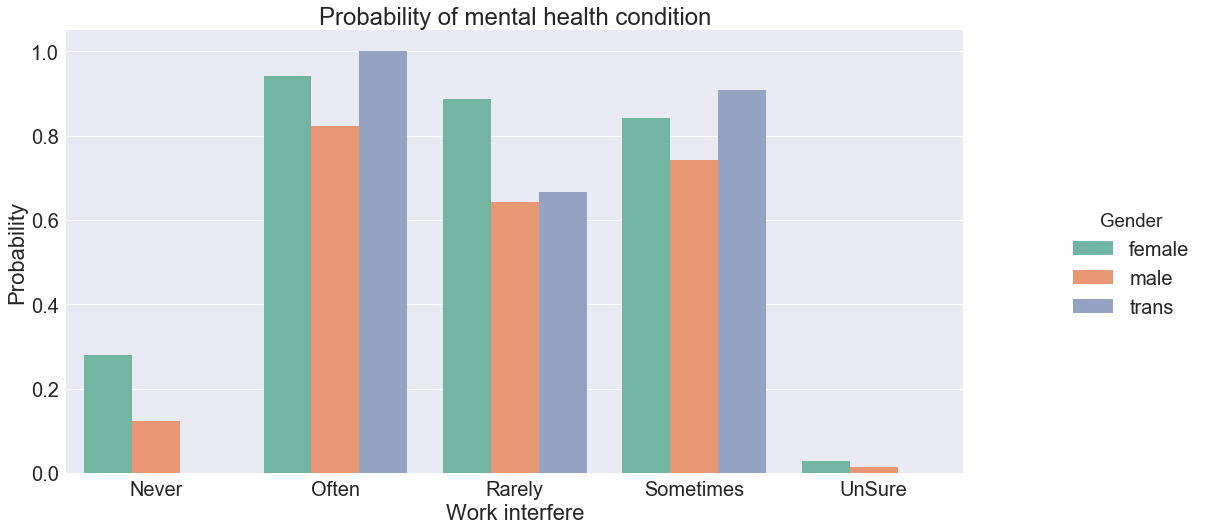

In [1813]:
o = labelDict['label_work_interfere']
g = sns.factorplot(x="work_interfere", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=8, aspect=2, legend_out = True, palette="Set2")
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability')
plt.xlabel('Work interfere')

new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

<b>From above bar plot we can conclude that even a little Work Interference can lead to mental issues.</b>

In [1814]:
feats=['range','mental_health_consequence','supervisor','phys_health_interview','coworkers','care_options_Yes','no_employees','leave','family_history','work_interfere','benefits_Yes','Gender_male']
#X = train_df_bkp[train_df_bkp.columns.difference(['Age','treatment','Gender_trans'])]
X = train_df_bkp[feats]
#X = train_df_bkp[feature_cols]
y = train_df_bkp.treatment

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print(X.columns)

methodDict = {}
rmseDict = ()

Index(['range', 'mental_health_consequence', 'supervisor',
       'phys_health_interview', 'coworkers', 'care_options_Yes',
       'no_employees', 'leave', 'family_history', 'work_interfere',
       'benefits_Yes', 'Gender_male'],
      dtype='object')


In [1815]:
scaler = MinMaxScaler()
train_df = train_df.drop(['Country'], axis= 1)
train_df_bkp = train_df_bkp.drop(['Country'], axis= 1)
train_df['Age'] = scaler.fit_transform(train_df[['Age']])

In [1816]:
def tuningRandomizedSearchCV(model, param_dist):
    #Searching multiple parameters simultaneously
    # n_iter controls the number of searches
    rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
    rand.fit(X, y)
    rand.grid_scores_
    
    # examine the best model
    print('Rand. Best Score: ', rand.best_score_)
    print('Rand. Best Params: ', rand.best_params_)
    
    # run RandomizedSearchCV 20 times (with n_iter=10) and record the best score
    best_scores = []
    for _ in range(20):
        rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10)
        rand.fit(X, y)
        best_scores.append(round(rand.best_score_, 3))
    print(best_scores)
    return rand.best_params_

In [1817]:
from IPython.display import display, 

def evalClassModel(model, y_test, y_pred_class, plot=False):
    
    measures=pd.DataFrame(columns=["Measure","Value"])
    measures.loc[0]=['Accuracy:', metrics.accuracy_score(y_test, y_pred_class)]
    measures.loc[1]=['Percentage of ones:', y_test.mean()]
    measures.loc[2]=['Percentage of zeros:',1 - y_test.mean()]
    
    display(HTML(measures.to_html()))
    
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # visualize Confusion Matrix
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    measures=pd.DataFrame(columns=["Measure","Value"])
    
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    measures.loc[0]=['Classification Accuracy:', accuracy]
    measures.loc[1]=['Classification Error:', 1 - metrics.accuracy_score(y_test, y_pred_class)]
    false_positive_rate = FP / float(TN + FP)
    measures.loc[2]=['False Positive Rate:', false_positive_rate]
    measures.loc[3]=['Precision:', metrics.precision_score(y_test, y_pred_class)]
    measures.loc[4]=['Recall:', metrics.recall_score(y_test, y_pred_class)]
    measures.loc[5]=['AUC Score:', metrics.roc_auc_score(y_test, y_pred_class)]   
    measures.loc[6]=['Cross-validated accuracy:', cross_val_score(model, X, y, cv=10).mean()]
    measures.loc[7]=['Cross-validated AUC:', cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean()]
    
    display(HTML(measures.to_html()))
    
    # store the predicted probabilities for class 1
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)
    
    

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    if plot == True:
        plt.figure()
        
        plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for treatment classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()    
    
    return accuracy

Index(['range', 'mental_health_consequence', 'supervisor',
       'phys_health_interview', 'coworkers', 'care_options_Yes',
       'no_employees', 'leave', 'family_history', 'work_interfere',
       'benefits_Yes', 'Gender_male'],
      dtype='object')
[ 9  8  6  7  3  1  4  5  2  0 10 11]
[0.04690561 0.05410705 0.04955141 0.05904883 0.05317236 0.05176531
 0.08521633 0.08195109 0.09624955 0.3565842  0.03553686 0.02991141]


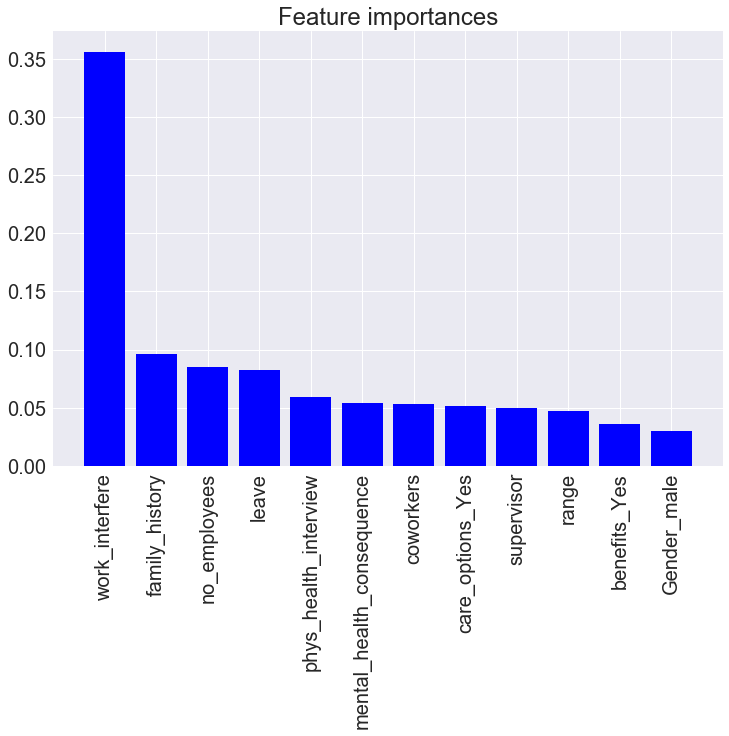

In [1818]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)


print(X.columns)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
print(indices)
labels = []
#for f in range(X.shape[1]):
#    labels.append(feature_cols[f])

for f in indices:
    labels.append(X.columns[f])

print(importances)    
# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
#plt.bar(range(X.shape[1]), importances[indices],
#       color="r", yerr=std[indices], align="center")
plt.bar(range(X.shape[1]), importances[indices],
       color="b",  align="center")
plt.xticks(range(X.shape[1]), labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

In [1819]:
def logisticRegression():
    # train a logistic regression model on the training set
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = logreg.predict(X_test)
    
    print('########### Logistic Regression ###############')
    
    accuracy_score = evalClassModel(logreg, y_test, y_pred_class, True)
    
    #Data for final graph
    methodDict['Log. Regres.'] = accuracy_score * 100

########### Logistic Regression ###############


,Measure,Value
0,Accuracy:,0.804233
1,Percentage of ones:,0.502646
2,Percentage of zeros:,0.497354


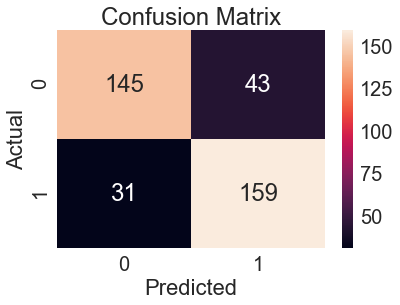

,Measure,Value
0,Classification Accuracy:,0.804233
1,Classification Error:,0.195767
2,False Positive Rate:,0.228723
3,Precision:,0.787129
4,Recall:,0.836842
5,AUC Score:,0.804059
6,Cross-validated accuracy:,0.813284
7,Cross-validated AUC:,0.874993


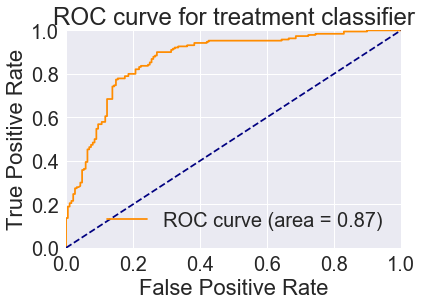

In [1820]:
logisticRegression()

<b>Used Wrapper method as well for feature selection but accuracy was lesser</b>

In [1821]:
from sklearn.feature_selection import RFE
X=train_df_bkp[train_df_bkp.columns.difference(['treatment'])]
Y=train_df_bkp['treatment']
selector = RFE(LogisticRegression(), 10, step=1)
selector = selector.fit(X, y)
selected=[]
for ind, val in enumerate(selector.support_):
    if val==True:
     selected.append(X.columns[ind])
#print(selector.ranking_)
X = train_df_bkp[selected]
y = train_df_bkp.treatment
reg1 = LogisticRegression()
reg1.fit(X_train,y_train)
predictions=reg1.predict(X_test)
print(metrics.accuracy_score(y_test,predictions))

0.8042328042328042


In [1822]:
def treeClassifier():
    # Calculating the best parameters
    tree = DecisionTreeClassifier()
    param_dist = {"max_depth": [3,X.shape[1]],
              "max_features": randint(1, X.shape[1]),
              "min_samples_split": randint(2, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
    
    params=tuningRandomizedSearchCV(tree, param_dist)
    
    # train a decision tree model on the training set
    tree = DecisionTreeClassifier(max_depth=params['max_depth'], min_samples_split=params['min_samples_split'], max_features=params['max_features'], criterion=params['criterion'], min_samples_leaf=params['min_samples_split'])
    tree.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = tree.predict(X_test)
    
    print('########### Tree classifier ###############')
    
    accuracy_score = evalClassModel(tree, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['Tree clas.'] = accuracy_score * 100

Rand. Best Score:  0.8308181096108023
Rand. Best Params:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 9, 'min_samples_leaf': 7, 'min_samples_split': 5}
[0.831, 0.831, 0.831, 0.811, 0.831, 0.822, 0.827, 0.831, 0.831, 0.831, 0.831, 0.805, 0.831, 0.831, 0.831, 0.831, 0.817, 0.828, 0.831, 0.823]
########### Tree classifier ###############


,Measure,Value
0,Accuracy:,0.809524
1,Percentage of ones:,0.502646
2,Percentage of zeros:,0.497354


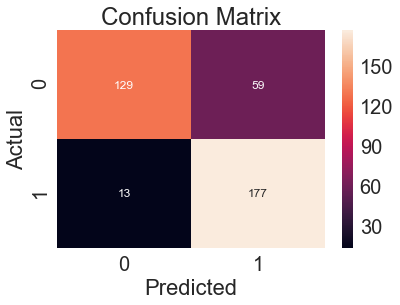

,Measure,Value
0,Classification Accuracy:,0.809524
1,Classification Error:,0.190476
2,False Positive Rate:,0.313830
3,Precision:,0.750000
4,Recall:,0.931579
5,AUC Score:,0.808875
6,Cross-validated accuracy:,0.808503
7,Cross-validated AUC:,0.874752


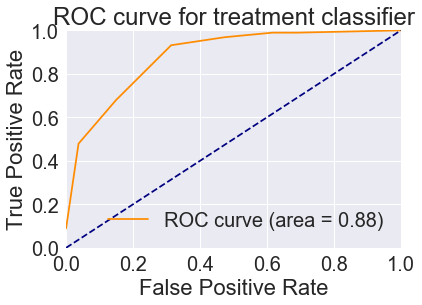

In [1823]:
treeClassifier()

In [1824]:
def bagging():
    bag = BaggingClassifier(DecisionTreeClassifier(max_depth=3), max_samples=1.0, max_features=1.0, bootstrap_features=True, n_estimators=40)
    bag.fit(X_train, y_train)
    y_pred_class = bag.predict(X_test)    
    print('########### Bagging ###############')
    accuracy_score = evalClassModel(bag, y_test, y_pred_class, True)
    methodDict['Bagging'] = accuracy_score * 100

########### Bagging ###############


,Measure,Value
0,Accuracy:,0.828042
1,Percentage of ones:,0.502646
2,Percentage of zeros:,0.497354


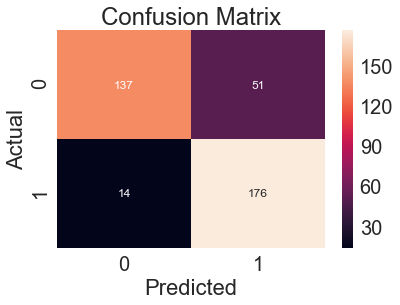

,Measure,Value
0,Classification Accuracy:,0.828042
1,Classification Error:,0.171958
2,False Positive Rate:,0.271277
3,Precision:,0.775330
4,Recall:,0.926316
5,AUC Score:,0.827520
6,Cross-validated accuracy:,0.828396
7,Cross-validated AUC:,0.899224


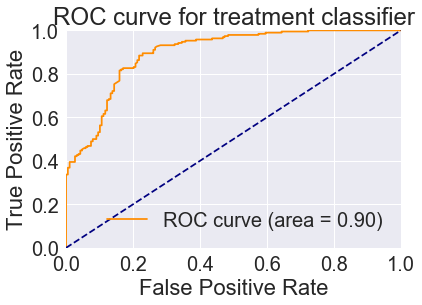

In [1825]:
bagging()

In [1826]:
def boosting():
    # Building and fitting 
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    boost = AdaBoostClassifier(base_estimator=clf, n_estimators=40)
    boost.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = boost.predict(X_test)
    
    print('########### Boosting ###############')
    
    accuracy_score = evalClassModel(boost, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['Boosting'] = accuracy_score * 100

########### Boosting ###############


,Measure,Value
0,Accuracy:,0.843915
1,Percentage of ones:,0.502646
2,Percentage of zeros:,0.497354


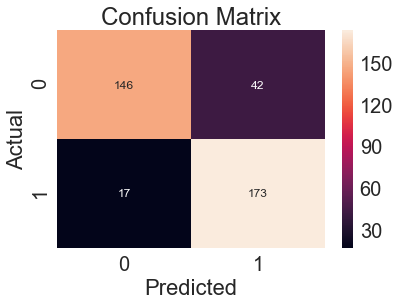

,Measure,Value
0,Classification Accuracy:,0.843915
1,Classification Error:,0.156085
2,False Positive Rate:,0.223404
3,Precision:,0.804651
4,Recall:,0.910526
5,AUC Score:,0.843561
6,Cross-validated accuracy:,0.827583
7,Cross-validated AUC:,0.904215


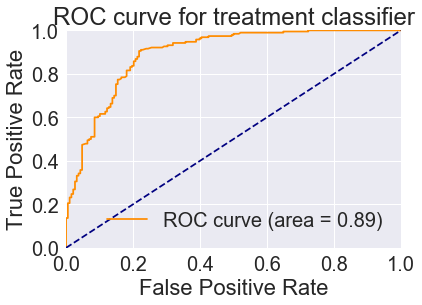

In [1827]:
boosting()

In [1828]:
def randomForest():
    # Calculating the best parameters
    forest = RandomForestClassifier(n_estimators = 20)

    param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_split": randint(2, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
    params=tuningRandomizedSearchCV(forest, param_dist)
    
    
    # train a decision tree model on the training set
    
    
    # Building and fitting my_forest
    forest = RandomForestClassifier(criterion = params['criterion'], max_features = params['max_features'], max_depth = params['max_depth'], min_samples_leaf=params['min_samples_leaf'], min_samples_split=params['min_samples_split'], n_estimators = 20, random_state = 1)
    my_forest = forest.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = my_forest.predict(X_test)
    
    print('########### Random Forests ###############')
    
    accuracy_score = evalClassModel(my_forest, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['R. Forest'] = accuracy_score * 100

Rand. Best Score:  0.8387609213661636
Rand. Best Params:  {'criterion': 'entropy', 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 7, 'min_samples_split': 3}
[0.831, 0.839, 0.833, 0.835, 0.833, 0.835, 0.836, 0.836, 0.831, 0.834, 0.838, 0.835, 0.832, 0.836, 0.833, 0.836, 0.831, 0.838, 0.833, 0.835]
########### Random Forests ###############


,Measure,Value
0,Accuracy:,0.822751
1,Percentage of ones:,0.502646
2,Percentage of zeros:,0.497354


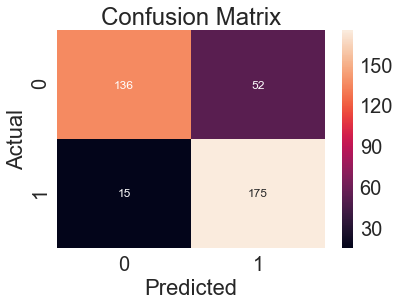

,Measure,Value
0,Classification Accuracy:,0.822751
1,Classification Error:,0.177249
2,False Positive Rate:,0.276596
3,Precision:,0.770925
4,Recall:,0.921053
5,AUC Score:,0.822228
6,Cross-validated accuracy:,0.831577
7,Cross-validated AUC:,0.895413


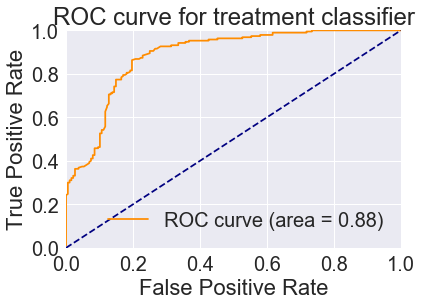

In [1829]:
randomForest()

In [1830]:
def plotSuccess():
    s = pd.Series(methodDict)
    s = s.sort_values(ascending=False)
    plt.figure(figsize=(12,8))
    ax = s.plot(kind='bar') 
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.ylim([70.0, 90.0])
    plt.xlabel('Method')
    plt.ylabel('Percentage')
    plt.title('Success of methods')
     
    plt.show()

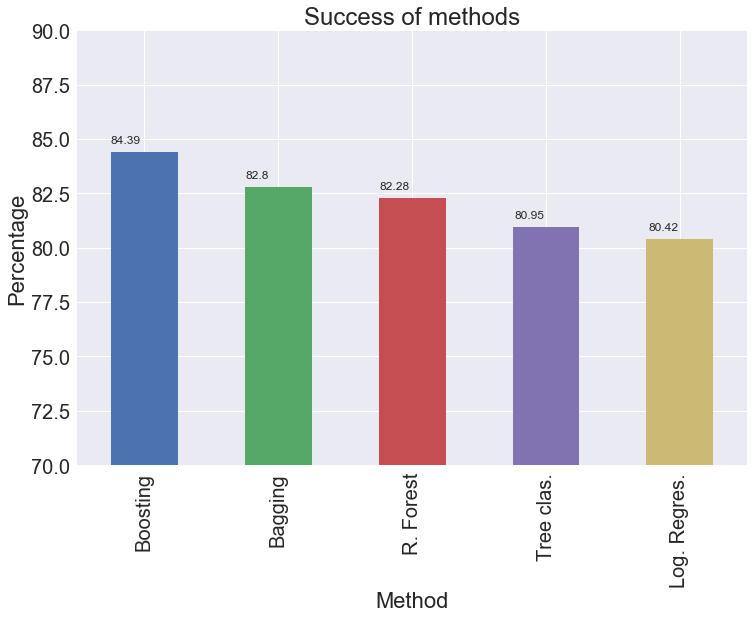

In [1831]:
plotSuccess()